# Term Deposit Marketing

We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

The contents of this script involves execution of following techniques with Random Forest:
- Random Grid Search
- SMOTE (Synthetic Minority Oversampling Technique)
- SMOTE with standard scaling
- Balanced Bagging Classifier
- SMOTE with robust scaling

Import necessary libraries

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## Data Description

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

Attributes:

- age : age of customer (numeric)

- job : type of job (categorical)

- marital : marital status (categorical)

- education (categorical)

- default: has credit in default? (binary)

- balance: average yearly balance, in euros (numeric)

- housing: has a housing loan? (binary)

- loan: has personal loan? (binary)

- contact: contact communication type (categorical)

- day: last contact day of the month (numeric)

- month: last contact month of year (categorical)

- duration: last contact duration, in seconds (numeric)

- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target):

- y - has the client subscribed to a term deposit? (binary)

In [2]:
df = pd.read_csv('term-deposit-marketing-2020.csv')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


## Exploratory Data Analysis

This step investigate the following steps:
- Check for missing values
- Investigate the distribution of numerical variables
- Idenitfy number of categories in categorical features
- Compute the correlation between input and output variables

1. Check for missing value

In [4]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

This data set does not contain any missing values.

2. Investigate the distribution of numerical variables

In [5]:
df.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>,
        <Axes: title={'center': 'day'}>],
       [<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'campaign'}>, <Axes: >]], dtype=object)

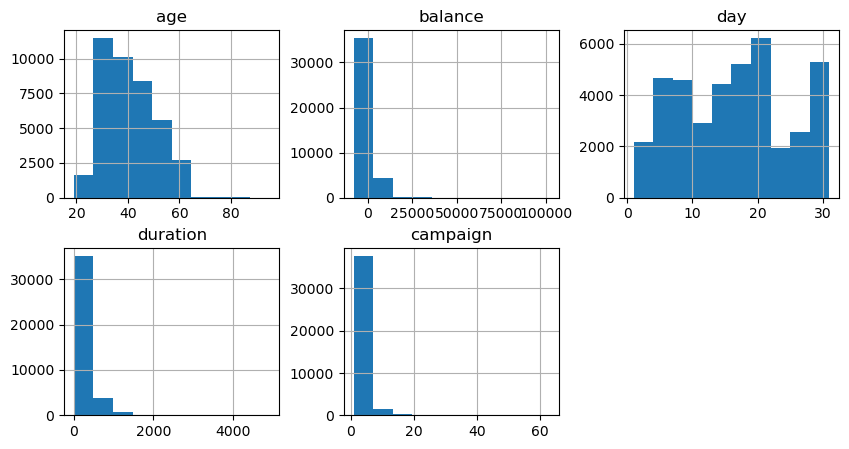

In [6]:
df.hist(figsize=(10, 5), layout=(2, 3))

The difference in range of numerical features is considerable. Standarization ('age' and 'day') might help increase the model accuracy. Other variables are positively skewed and has large outliers.

3. Idenitfy number of categories in categorical features

In [7]:
print('Number of unique values/Categories:')
for col in df.columns:
    print('- '+col+': ', df[col].nunique())

Number of unique values/Categories:
- age:  70
- job:  12
- marital:  3
- education:  4
- default:  2
- balance:  6849
- housing:  2
- loan:  2
- contact:  3
- day:  31
- month:  11
- duration:  1535
- campaign:  48
- y:  2


'education' and 'marital' are categorial object with 4 and 3 unique values, respectively.

In [8]:
df['education'].unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

In [9]:
df['marital'].unique()

array(['married', 'single', 'divorced'], dtype=object)

In [10]:
df_dummies = pd.get_dummies(df, columns=['job', 'marital', 'default', 'housing', 'loan', 'contact'], drop_first=True, dtype=float)

In [11]:
df_dummies.head()

,age,education,balance,day,month,duration,campaign,y,job_blue-collar,job_entrepreneur,...,job_technician,job_unemployed,job_unknown,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown
0,58,tertiary,2143,5,may,261,1,no,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,44,secondary,29,5,may,151,1,no,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,33,secondary,2,5,may,76,1,no,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
3,47,unknown,1506,5,may,92,1,no,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,33,unknown,1,5,may,198,1,no,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [12]:
education_dict = {'tertiary': 3, 'secondary': 2, 'unknown': 0, 'primary': 1}
df_dummies['ordinal_education'] = df_dummies.education.map(education_dict)
df_dummies = df_dummies.drop('education', axis=1)
df_dummies.head()

,age,balance,day,month,duration,campaign,y,job_blue-collar,job_entrepreneur,job_housemaid,...,job_unemployed,job_unknown,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,ordinal_education
0,58,2143,5,may,261,1,no,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,3
1,44,29,5,may,151,1,no,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2
2,33,2,5,may,76,1,no,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2
3,47,1506,5,may,92,1,no,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
4,33,1,5,may,198,1,no,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0


In [13]:
cat_columns = df_dummies.select_dtypes(['object']).columns
cat_columns

Index(['month', 'y'], dtype='object')

In [14]:
df_dummies[cat_columns] = df_dummies[cat_columns].apply(lambda x: pd.factorize(x)[0])
df_dummies.head()

,age,balance,day,month,duration,campaign,y,job_blue-collar,job_entrepreneur,job_housemaid,...,job_unemployed,job_unknown,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,ordinal_education
0,58,2143,5,0,261,1,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,3
1,44,29,5,0,151,1,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2
2,33,2,5,0,76,1,0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2
3,47,1506,5,0,92,1,0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
4,33,1,5,0,198,1,0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0


4. Compute the correlation between input and output variables 

In [15]:
df_dummies.corr().style.background_gradient(cmap='coolwarm')

,age,balance,day,month,duration,campaign,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,ordinal_education
age,1.000000,0.081517,-0.011689,0.022965,-0.036270,0.016204,-0.020273,-0.028956,0.027956,0.084920,-0.005302,0.333164,0.001712,-0.057227,-0.155146,-0.058308,0.008052,0.043904,0.265630,-0.408589,-0.014857,-0.179606,0.000041,0.120689,0.010386,-0.161471
balance,0.081517,1.000000,0.011662,0.059003,0.014072,-0.008137,0.030232,-0.041461,0.011692,0.003044,0.072172,0.015917,0.015771,-0.033618,0.000575,-0.012655,0.010020,0.010672,0.023683,-0.007168,-0.070069,-0.049946,-0.080596,0.029116,-0.018851,0.052765
day,-0.011689,0.011662,1.000000,0.029379,-0.032983,0.165429,-0.006420,-0.035006,-0.003629,0.005355,0.026526,-0.002787,0.005080,-0.009461,-0.011183,0.031902,-0.005475,-0.009526,0.005243,-0.002806,0.006287,-0.050622,0.005838,0.037242,-0.054363,0.032272
month,0.022965,0.059003,0.029379,1.000000,0.015157,-0.069674,0.106168,-0.096244,0.000201,-0.004050,0.057380,0.022085,0.020090,-0.031792,0.032897,0.017347,0.061696,-0.003019,-0.011074,0.024891,-0.024357,-0.167039,-0.014806,0.077645,-0.506906,0.085241
duration,-0.036270,0.014072,-0.032983,0.015157,1.000000,-0.088387,0.461169,0.015951,0.000247,-0.007239,-0.010846,0.001675,0.008821,0.003569,-0.007175,-0.008469,0.017896,-0.007971,-0.029153,0.026703,-0.008597,0.022455,-0.003952,-0.040379,0.001928,0.004813
campaign,0.016204,-0.008137,0.165429,-0.069674,-0.088387,1.000000,-0.040350,-0.004635,-0.002619,0.002804,0.021105,-0.013881,0.004581,-0.010404,-0.008503,0.018915,-0.017052,0.017037,0.027962,-0.016179,0.012135,-0.054823,0.000582,0.061620,-0.012468,0.006220
y,-0.020273,0.030232,-0.006420,0.106168,0.461169,-0.040350,1.000000,-0.032859,-0.007191,-0.015248,0.020291,0.024343,0.005029,-0.014645,0.037384,0.000234,0.009463,-0.000018,-0.056863,0.051721,-0.006559,-0.054336,-0.031029,-0.000842,-0.088408,0.043828
job_blue-collar,-0.028956,-0.041461,-0.035006,-0.096244,0.015951,-0.004635,-0.032859,1.000000,-0.105624,-0.092525,-0.280381,-0.106864,-0.105974,-0.182215,-0.063781,-0.251692,-0.093266,-0.042557,0.125618,-0.087522,0.004706,0.156122,0.005674,0.006448,0.116781,-0.374273
job_entrepreneur,0.027956,0.011692,-0.003629,0.000201,0.000247,-0.002619,-0.007191,-0.105624,1.000000,-0.031889,-0.096634,-0.036831,-0.036524,-0.062801,-0.021982,-0.086747,-0.032144,-0.014667,0.044941,-0.048960,0.025645,0.003303,0.038244,-0.006114,-0.002439,0.045729
job_housemaid,0.084920,0.003044,0.005355,-0.004050,-0.007239,0.002804,-0.015248,-0.092525,-0.031889,1.000000,-0.084650,-0.032263,-0.031995,-0.055013,-0.019256,-0.075988,-0.028158,-0.012848,0.046431,-0.061803,0.000017,-0.086038,-0.016788,0.037439,-0.003592,-0.108081


- Input feature 'duration' has 0.461 correlation to output variable 'y'. This is expected as longer call duration can signify that customer is interested and might end up subscribing.

- 'job_management' and 'ordinal_education' has correlation 0.455.

- 'job_retired' and 'age' has correlation value 0.33.

## Training

In [16]:
X = df_dummies.loc[:, ~df_dummies.columns.isin(['y'])]
y = df_dummies['y']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [18]:
X_train.describe(), X_test.describe()

(                age       balance           day         month      duration  \
 count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
 mean      40.523133   1270.318267     16.005000      2.690600    255.211233   
 std        9.646086   2888.033116      8.279114      3.069547    261.413276   
 min       19.000000  -8019.000000      1.000000      0.000000      0.000000   
 25%       33.000000     55.000000      8.000000      0.000000    100.000000   
 50%       39.000000    406.000000     16.000000      2.000000    174.000000   
 75%       48.000000   1317.000000     21.000000      5.000000    313.000000   
 max       95.000000  98417.000000     31.000000     10.000000   4918.000000   
 
            campaign  job_blue-collar  job_entrepreneur  job_housemaid  \
 count  30000.000000     30000.000000       30000.00000   30000.000000   
 mean       2.882033         0.234833           0.03530       0.026600   
 std        3.249647         0.423902           0.18454 

In [19]:
scaler = StandardScaler().set_output(transform="pandas")
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X_train.describe(), scaled_X_test.describe()

(                age       balance           day         month      duration  \
 count  3.000000e+04  3.000000e+04  3.000000e+04  3.000000e+04  3.000000e+04   
 mean  -5.163277e-17  7.105427e-19  1.160553e-16  5.992244e-17  2.889540e-17   
 std    1.000017e+00  1.000017e+00  1.000017e+00  1.000017e+00  1.000017e+00   
 min   -2.231319e+00 -3.216540e+00 -1.812422e+00 -8.765609e-01 -9.762912e-01   
 25%   -7.799287e-01 -4.208188e-01 -9.669070e-01 -8.765609e-01 -5.937488e-01   
 50%   -1.579043e-01 -2.992807e-01 -6.039394e-04 -2.249881e-01 -3.106674e-01   
 75%    7.751322e-01  1.616412e-02  6.033355e-01  7.523711e-01  2.210665e-01   
 max    5.647656e+00  3.363822e+01  1.811214e+00  2.381303e+00  1.783714e+01   
 
            campaign  job_blue-collar  job_entrepreneur  job_housemaid  \
 count  3.000000e+04     3.000000e+04      3.000000e+04   3.000000e+04   
 mean   2.232288e-17    -5.092223e-17      6.679102e-17   2.036889e-17   
 std    1.000017e+00     1.000017e+00      1.000017e+00 

In [20]:
def print_metrics(test, predictions):
    """
    This function compute and print the accuracy, precision, recall, F1-score and Roc-Auc score.
    """
    accuracy = accuracy_score(test, predictions)
    precision = precision_score(test, predictions)
    recall = recall_score(test, predictions)
    roc_auc = roc_auc_score(test, predictions)
    f1 = f1_score(test, predictions)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("Roc Auc:", roc_auc)

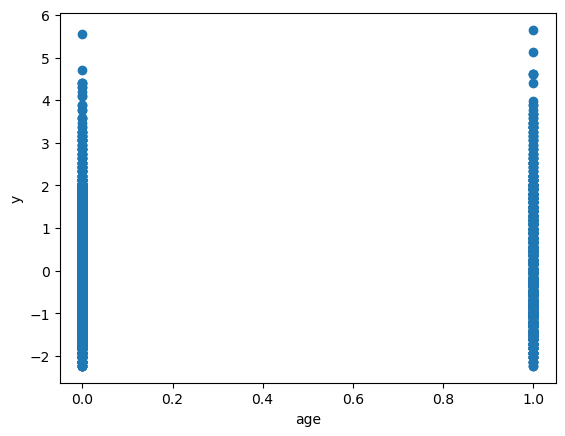

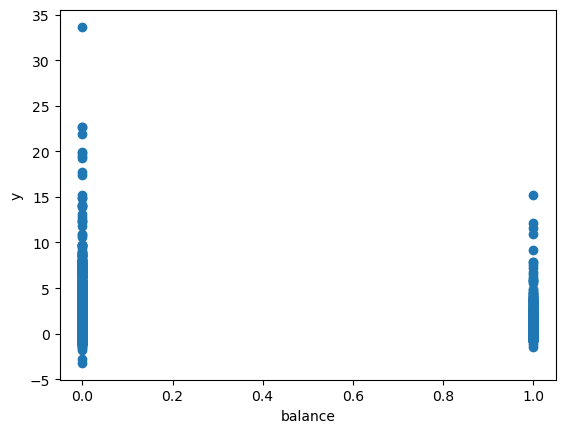

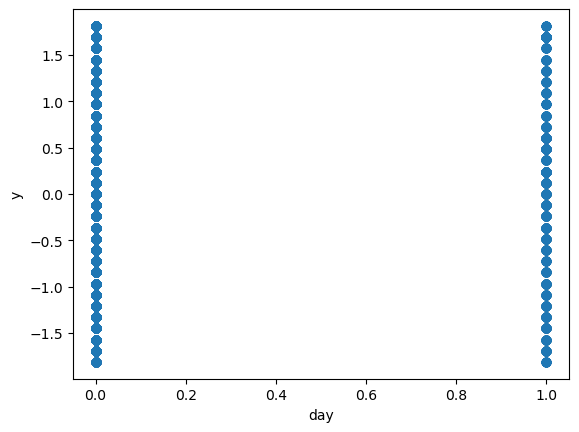

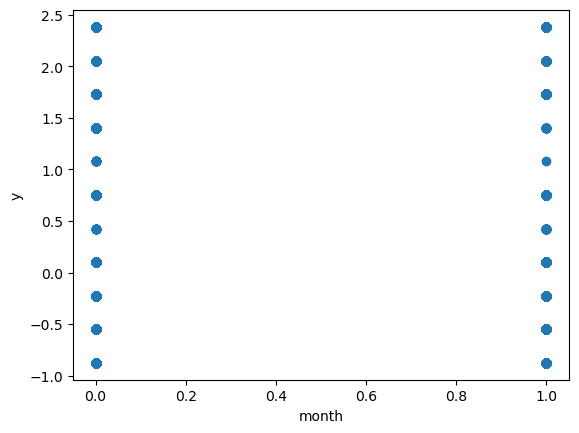

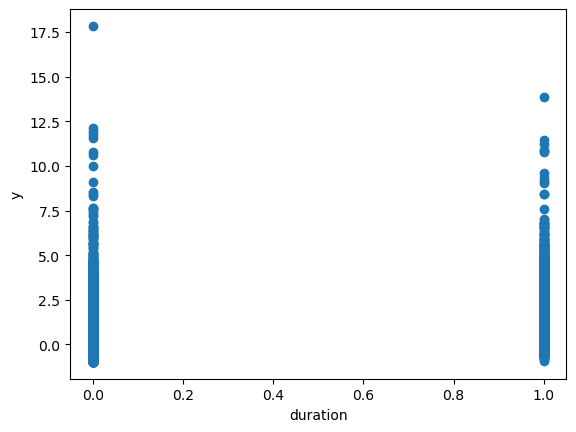

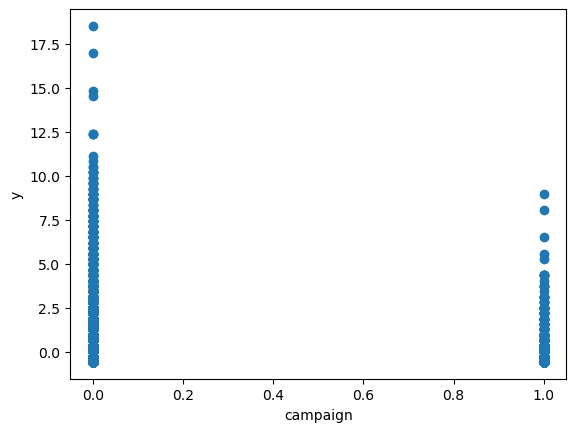

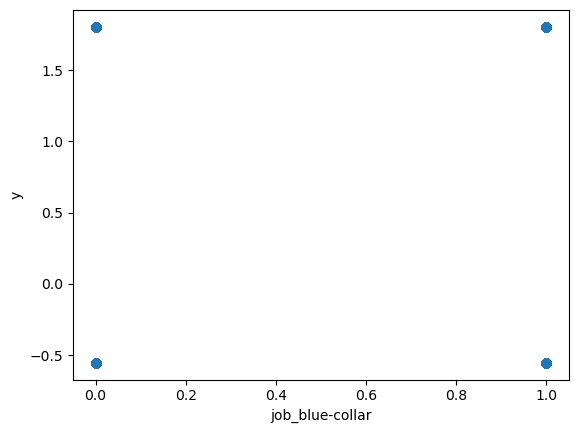

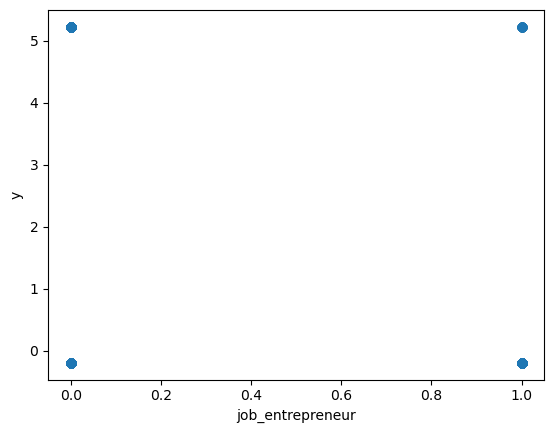

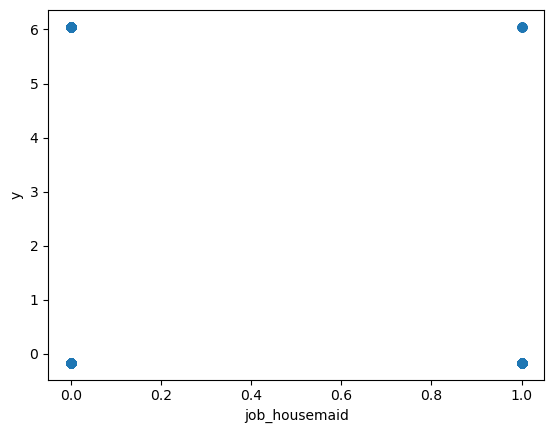

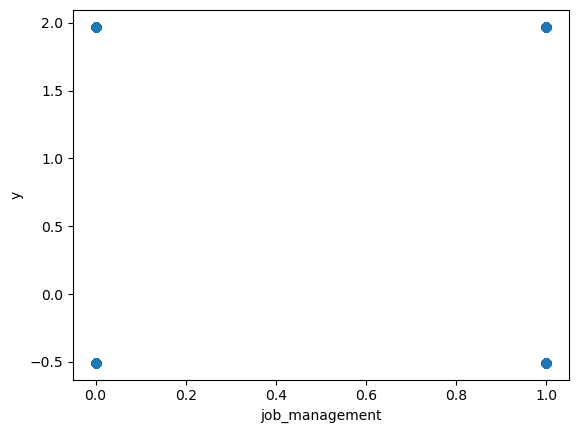

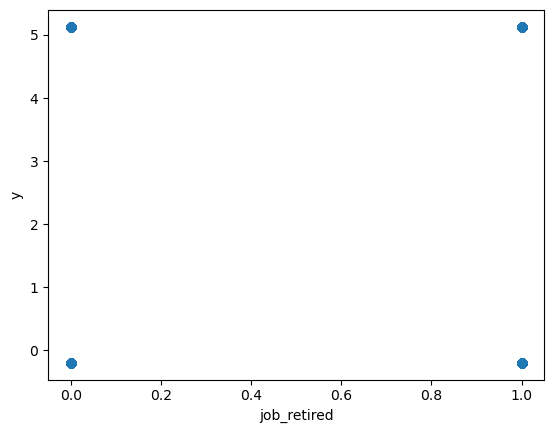

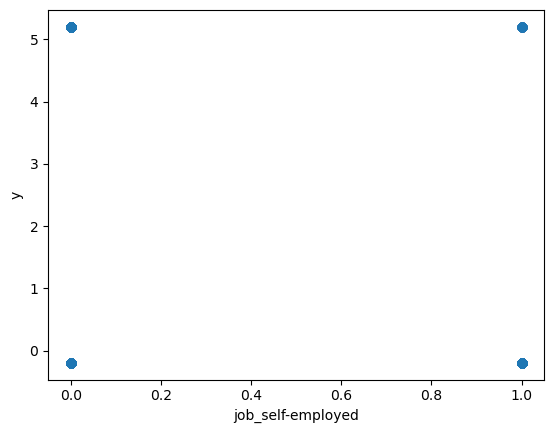

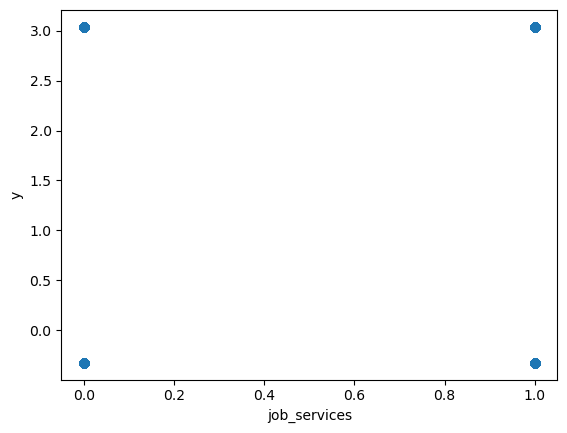

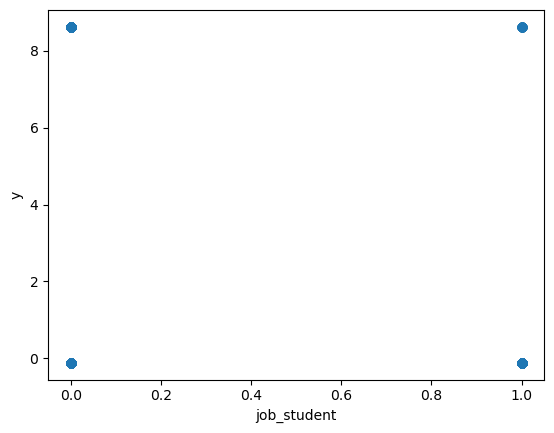

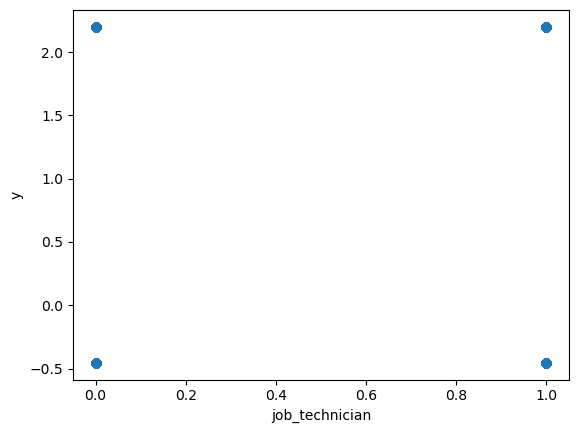

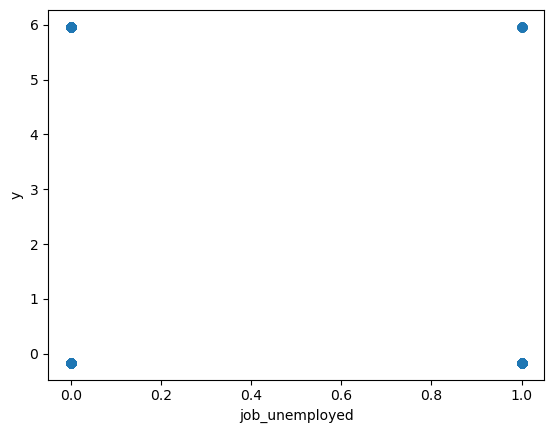

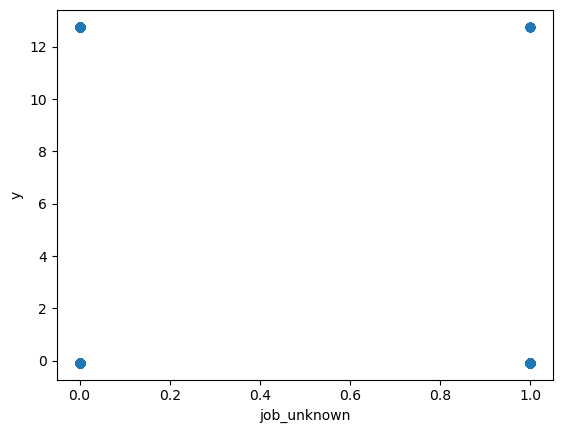

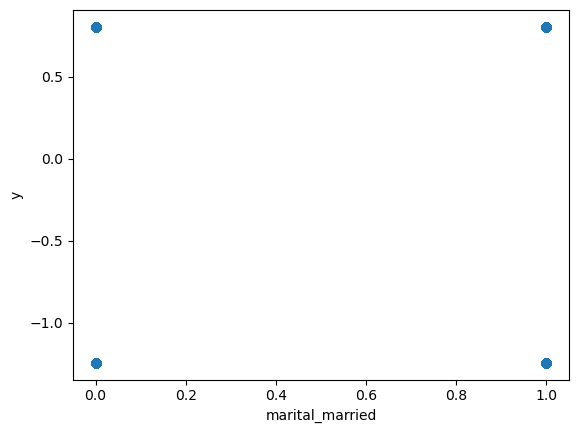

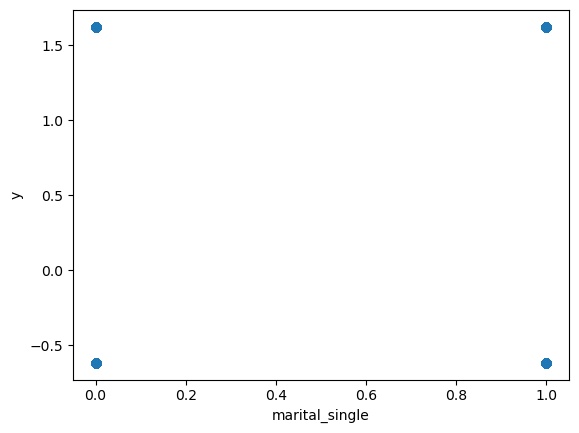

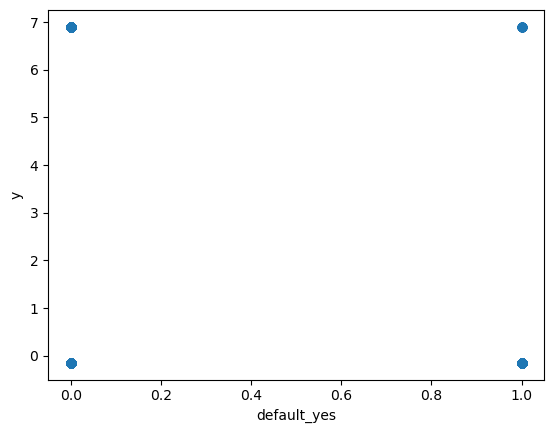

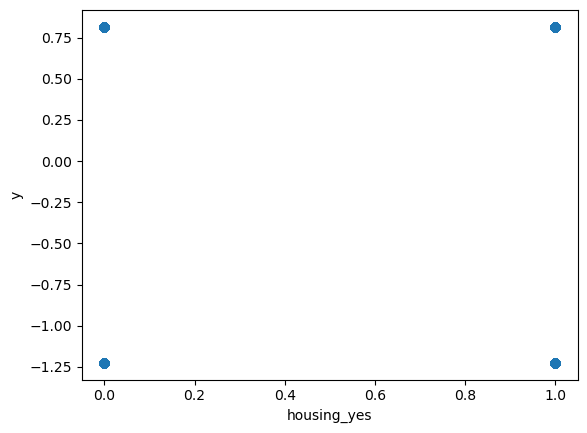

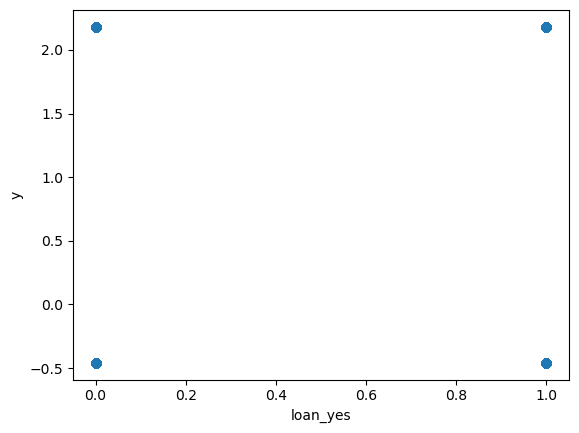

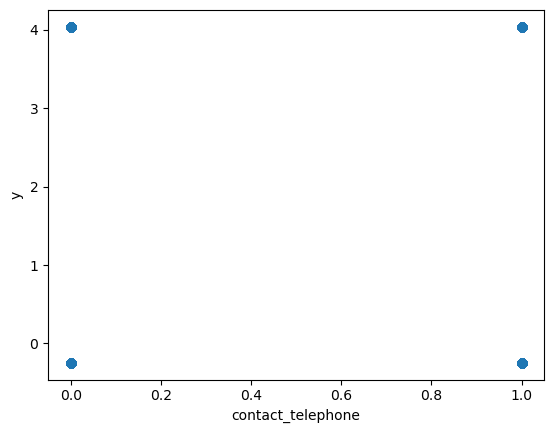

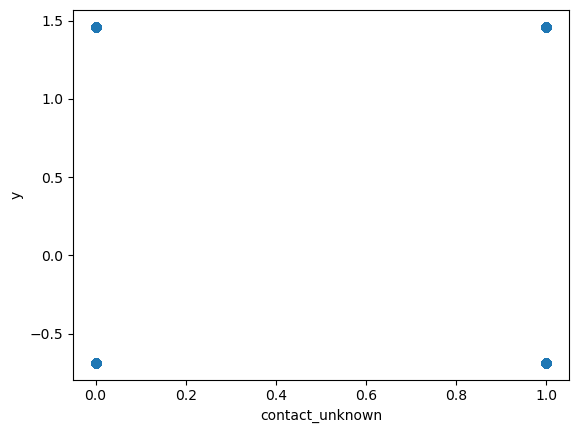

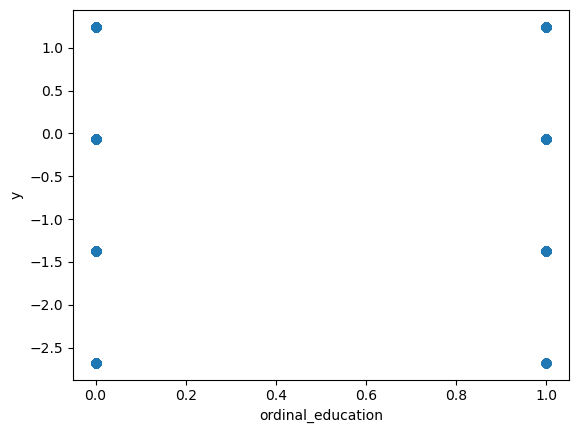

In [21]:
for col in X_train.columns:
    plt.figure()
    plt.scatter(y_train, scaled_X_train[col])
    plt.xlabel(col)
    plt.ylabel('y')
    plt.show()

### Randomized Grid Search

In [22]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

Use the random grid to search for best hyperparameters.

In [23]:
# First create the base model to tune
rf = RandomForestClassifier(class_weight='balanced')
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, 
                               verbose=0, random_state=42, n_jobs = -1, scoring='roc_auc')
# Fit the random search model
rf_random.fit(X_train, y_train)

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='roc_auc')

In [24]:
best_rf = rf_random.best_estimator_
rf_random.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=60,
                       min_samples_leaf=2, n_estimators=1000)

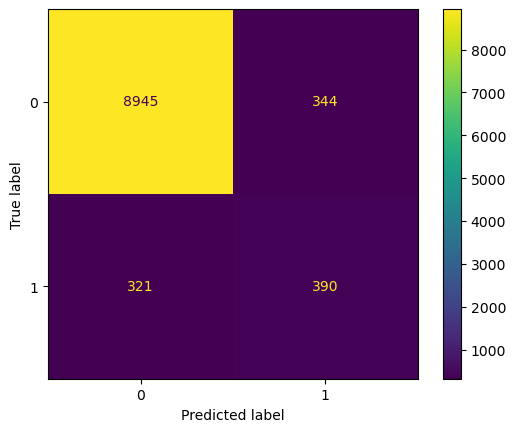

In [25]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [26]:
print_metrics(y_test, y_pred)

Accuracy: 0.9335
Precision: 0.5313351498637602
Recall: 0.5485232067510548
F1-score: 0.5397923875432526
Roc Auc: 0.7557450784535766


## SMOTE (Synthetic Minority OverSampling Technique)

In [27]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
print(imblearn.__version__)

0.11.0


In [28]:
model = RandomForestClassifier(class_weight='balanced')
over = SMOTE(sampling_strategy=0.3, k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

In [29]:
random_grid = {'model__n_estimators': n_estimators,
               'model__max_features': max_features,
               'model__max_depth': max_depth,
               'model__min_samples_split': min_samples_split,
               'model__min_samples_leaf': min_samples_leaf,
               'model__bootstrap': bootstrap}

In [30]:
rf_random = RandomizedSearchCV(pipeline, param_distributions = random_grid, n_iter = 100, cv = 5, 
                               verbose=0, random_state=42, n_jobs = -1, scoring='roc_auc')

rf_random.fit(X_train, y_train)

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('over',
                                              SMOTE(sampling_strategy=0.3)),
                                             ('under',
                                              RandomUnderSampler(sampling_strategy=0.5)),
                                             ('model',
                                              RandomForestClassifier(class_weight='balanced'))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'model__bootstrap': [True, False],
                                        'model__max_depth': [10, 20, 30, 40, 50,
                                                             60, 70, 80, 90,
                                                             100, 110, None],
                                        'model__max_features': ['log2', 'sqrt'],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [200, 400, 600,
                                                                800, 1000, 1200,
                                                                1400, 1600,
                                                                1800, 2000]},
                   random_state=42, scoring='roc_auc')

In [31]:
best_rf = rf_random.best_estimator_
rf_random.best_estimator_

Pipeline(steps=[('over', SMOTE(sampling_strategy=0.3)),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('model',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight='balanced', max_depth=30,
                                        min_samples_split=10,
                                        n_estimators=1800))])

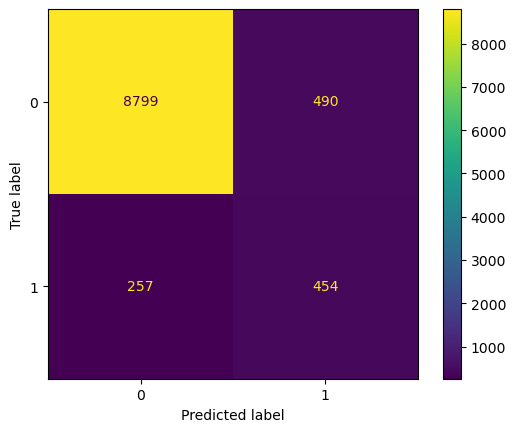

In [32]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [33]:
print_metrics(y_test, y_pred)

Accuracy: 0.9253
Precision: 0.4809322033898305
Recall: 0.6385372714486639
F1-score: 0.5486404833836859
Roc Auc: 0.7928933531320185


## SMOTE with scaled samples

In [34]:
model = RandomForestClassifier(class_weight='balanced')
over = SMOTE(sampling_strategy=0.3, k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

In [35]:
rf_random = RandomizedSearchCV(pipeline, param_distributions = random_grid, n_iter = 100, cv = 5, 
                               verbose=0, random_state=42, n_jobs = -1, scoring='roc_auc')

rf_random.fit(scaled_X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('over',
                                              SMOTE(sampling_strategy=0.3)),
                                             ('under',
                                              RandomUnderSampler(sampling_strategy=0.5)),
                                             ('model',
                                              RandomForestClassifier(class_weight='balanced'))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'model__bootstrap': [True, False],
                                        'model__max_depth': [10, 20, 30, 40, 50,
                                                             60, 70, 80, 90,
                                                             100, 110, None],
                                        'model__max_features': ['log2', 'sqrt'],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [200, 400, 600,
                                                                800, 1000, 1200,
                                                                1400, 1600,
                                                                1800, 2000]},
                   random_state=42, scoring='roc_auc')

In [36]:
best_rf = rf_random.best_estimator_
rf_random.best_estimator_

Pipeline(steps=[('over', SMOTE(sampling_strategy=0.3)),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('model',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight='balanced', max_depth=30,
                                        min_samples_leaf=4,
                                        n_estimators=600))])

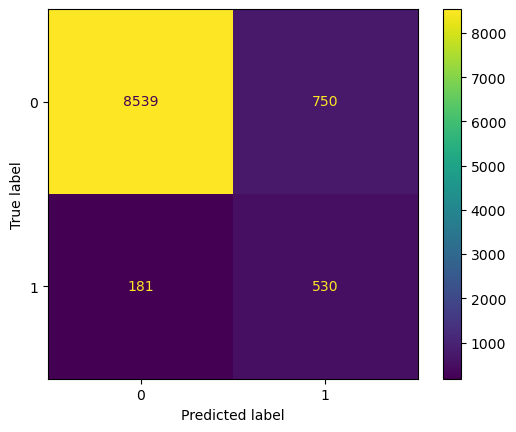

In [37]:
# Generate predictions with the best model
y_pred = best_rf.predict(scaled_X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [38]:
print_metrics(y_test, y_pred)

Accuracy: 0.9069
Precision: 0.4140625
Recall: 0.7454289732770746
F1-score: 0.5323957810145656
Roc Auc: 0.8323441561400982


## Balanced Bagging Classifier

In [39]:
from imblearn.ensemble import BalancedBaggingClassifier

In [40]:
base_estimator = RandomForestClassifier()
bbc = BalancedBaggingClassifier(base_estimator=base_estimator, sampling_strategy='auto', replacement=False, random_state=42)

In [41]:
random_grid = {'base_estimator__n_estimators': n_estimators,
               'base_estimator__max_features': max_features,
               'base_estimator__max_depth': max_depth,
               'base_estimator__min_samples_split': min_samples_split,
               'base_estimator__min_samples_leaf': min_samples_leaf,
               'base_estimator__bootstrap': bootstrap}

In [42]:
rf_random = RandomizedSearchCV(bbc, param_distributions = random_grid, n_iter = 100, cv = 5, 
                               verbose=0, random_state=42, n_jobs = -1, scoring='roc_auc')

rf_random.fit(scaled_X_train, y_train)

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimato

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimato

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimato

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimato

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimato

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimato

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimato

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimato

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimato

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimato

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimato

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimato

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimato

RandomizedSearchCV(cv=5,
                   estimator=BalancedBaggingClassifier(base_estimator=RandomForestClassifier(),
                                                       random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'base_estimator__bootstrap': [True,
                                                                      False],
                                        'base_estimator__max_depth': [10, 20,
                                                                      30, 40,
                                                                      50, 60,
                                                                      70, 80,
                                                                      90, 100,
                                                                      110,
                                                                      None],
                                        'base_estimator__max_features': ['log2',
                                                                         'sqrt'],
                                        'base_estimator__min_samples_leaf': [1,
                                                                             2,
                                                                             4],
                                        'base_estimator__min_samples_split': [2,
                                                                              5,
                                                                              10],
                                        'base_estimator__n_estimators': [200,
                                                                         400,
                                                                         600,
                                                                         800,
                                                                         1000,
                                                                         1200,
                                                                         1400,
                                                                         1600,
                                                                         1800,
                                                                         2000]},
                   random_state=42, scoring='roc_auc')

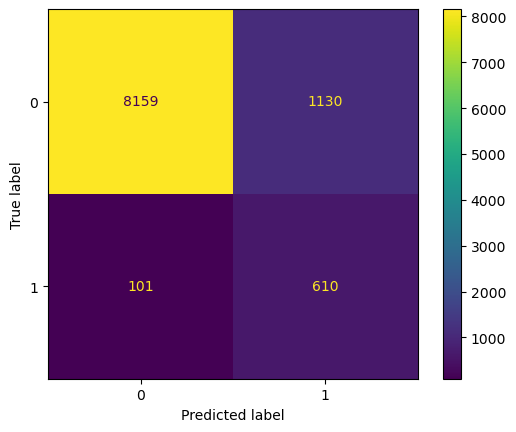

In [43]:
best_rf = rf_random.best_estimator_
rf_random.best_estimator_

# Generate predictions with the best model
y_pred = best_rf.predict(scaled_X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [44]:
print_metrics(y_test, y_pred)

Accuracy: 0.8769
Precision: 0.3505747126436782
Recall: 0.8579465541490858
F1-score: 0.49775601795185637
Roc Auc: 0.8681486457902281


## SMOTE with Robust Scaling

In [45]:
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler().set_output(transform="pandas")
rscaled_X = robust_scaler.fit_transform(X)

In [46]:
rscaled_X_train, rscaled_X_test, y_train, y_test = train_test_split(rscaled_X, y, test_size=0.25)
rscaled_X_train.describe(), rscaled_X_test.describe()

(                age       balance           day         month      duration  \
 count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
 mean       0.103802      0.687826     -0.077033      0.141213      0.375394   
 std        0.641392      2.331581      0.638667      0.615837      1.214807   
 min       -1.333333     -5.734387     -1.230769     -0.400000     -0.821596   
 25%       -0.400000     -0.277668     -0.692308     -0.400000     -0.356808   
 50%        0.000000      0.001581     -0.076923      0.000000      0.000000   
 75%        0.600000      0.723320      0.307692      0.600000      0.652582   
 max        3.733333     80.411067      1.076923      1.600000     22.267606   
 
            campaign  job_blue-collar  job_entrepreneur  job_housemaid  \
 count  30000.000000     30000.000000      30000.000000   30000.000000   
 mean       0.433533         0.233767          0.034700       0.026600   
 std        1.609146         0.423233          0.183022 

In [47]:
model = RandomForestClassifier(class_weight='balanced')
over = SMOTE(sampling_strategy=0.3, k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

In [48]:
random_grid = {'model__n_estimators': n_estimators,
               'model__max_features': max_features,
               'model__max_depth': max_depth,
               'model__min_samples_split': min_samples_split,
               'model__min_samples_leaf': min_samples_leaf,
               'model__bootstrap': bootstrap}

In [49]:
rf_random = RandomizedSearchCV(pipeline, param_distributions = random_grid, n_iter = 100, cv = 5, 
                               verbose=0, random_state=42, n_jobs = -1, scoring='roc_auc')

rf_random.fit(rscaled_X_train, y_train)

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('over',
                                              SMOTE(sampling_strategy=0.3)),
                                             ('under',
                                              RandomUnderSampler(sampling_strategy=0.5)),
                                             ('model',
                                              RandomForestClassifier(class_weight='balanced'))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'model__bootstrap': [True, False],
                                        'model__max_depth': [10, 20, 30, 40, 50,
                                                             60, 70, 80, 90,
                                                             100, 110, None],
                                        'model__max_features': ['log2', 'sqrt'],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [200, 400, 600,
                                                                800, 1000, 1200,
                                                                1400, 1600,
                                                                1800, 2000]},
                   random_state=42, scoring='roc_auc')

In [50]:
best_rf = rf_random.best_estimator_
rf_random.best_estimator_

Pipeline(steps=[('over', SMOTE(sampling_strategy=0.3)),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('model',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight='balanced', max_depth=30,
                                        min_samples_leaf=2,
                                        min_samples_split=10,
                                        n_estimators=800))])

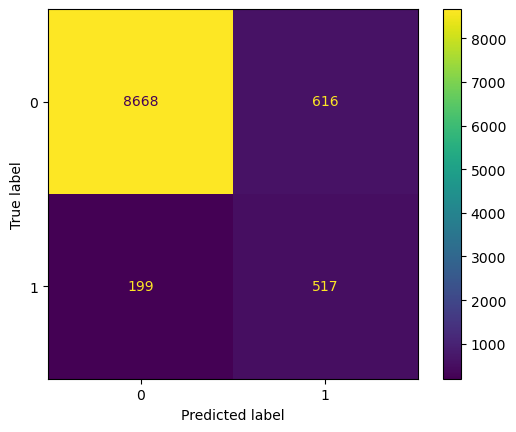

In [51]:
# Generate predictions with the best model
y_pred = best_rf.predict(rscaled_X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [52]:
print_metrics(y_test, y_pred)

Accuracy: 0.9185
Precision: 0.4563106796116505
Recall: 0.7220670391061452
F1-score: 0.5592212006489994
Roc Auc: 0.8278581641028356


## Conclusion

 - Random Grid Search achieved Roc-Auc accuracy of 0.7557
 - SMOTE achieved Roc-Auc accuracy of 0.7928
 - SMOTE (with standard scaling) achieved Roc-Auc accuracy of 0.8323
 - Balanced Bagged Classifier (with standard scaling) achieved Roc-Auc accuracy of 
 - SMOTE (with robust scaling) achieved Roc-Auc accuracy of 